# GNN Inference Notebook
Loads saved artifacts (model + config) and demonstrates batch toxicity prediction on comment graph.

## 1. Load Artifacts

In [25]:
import json, torch
from pathlib import Path
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import HeteroConv, SAGEConv, Linear

art_dir=Path('artifacts')
assert art_dir.exists(), 'artifacts/ missing. Train the model first.'
config=json.load(open(art_dir/'config.json'))
state=torch.load(art_dir/'model_best.pt', map_location='cpu')

# Try to load binary head bundle (optional)
bce_bundle_path = art_dir/'node_bce_head.pt'
has_bce_head = bce_bundle_path.exists()
head_state = None; temperature = 1.0
if has_bce_head:
    bundle = torch.load(bce_bundle_path, map_location='cpu')
    head_state = bundle.get('head_state', None)
    temperature = float(bundle.get('temperature', 1.0))
    print('Loaded BCE head and temperature from artifacts/node_bce_head.pt; T =', temperature)
else:
    print('No BCE head found; falling back to multi-class head outputs.')

# Mirror training-time HeteroGNN architecture
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden, out_classes, num_layers=2, dropout=0.3, edge_types=None):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.hidden = hidden
        self.out_classes = out_classes
        rels = set(edge_types or [])
        if not rels:
            raise ValueError('HeteroGNN requires at least one edge type; got none.')
        self.in_lins = nn.ModuleDict({
            'user': Linear(-1, hidden),
            'comment': Linear(-1, hidden),
        })
        def build_rel_dict():
            rel_dict = {}
            if ('user','authored','comment') in rels:
                rel_dict[('user','authored','comment')] = SAGEConv((hidden, hidden), hidden)
            if ('comment','replies_to','comment') in rels:
                rel_dict[('comment','replies_to','comment')] = SAGEConv((hidden, hidden), hidden)
            if ('comment','similar','comment') in rels:
                rel_dict[('comment','similar','comment')] = SAGEConv((hidden, hidden), hidden)
            return rel_dict
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(HeteroConv(build_rel_dict(), aggr='mean'))
        self.lin = Linear(hidden, out_classes)
    def forward(self, x_dict, edge_index_dict):
        x_dict = {k: self.in_lins[k](v) if k in self.in_lins else v for k, v in x_dict.items()}
        for conv in self.convs:
            out_dict = conv(x_dict, edge_index_dict)
            merged = {}
            for k in x_dict.keys():
                v = out_dict.get(k, x_dict[k])
                merged[k] = F.dropout(v.relu(), p=self.dropout, training=self.training)
            x_dict = merged
        return self.lin(x_dict['comment'])

# Build model with expected relations (create empty edges later if missing)
expected_edges = [
    ('user','authored','comment'),
    ('comment','replies_to','comment'),
    ('comment','similar','comment'),
 ]
model=HeteroGNN(
    config.get('gnn_hidden', 128),
    config.get('gnn_out_classes', 2),
    config.get('gnn_num_layers', 2),
    config.get('gnn_dropout', 0.3),
    edge_types=expected_edges
)

# Safely load checkpoint weights if shapes are compatible
def _safe_load(model, state):
    if isinstance(state, dict) and 'model_state' in state:
        sd = state['model_state']
    else:
        sd = state
    if not isinstance(sd, dict):
        print('Warning: checkpoint format not a dict; skipping weight load.')
        return
    msd = model.state_dict()
    compatible = {}
    skipped = []
    for k, v in sd.items():
        if k in msd and msd[k].shape == v.shape:
            compatible[k] = v
        else:
            skipped.append(k)
    if compatible:
        msd.update(compatible)
        model.load_state_dict(msd)
        print(f'Loaded {len(compatible)} layers; skipped {len(skipped)} (shape/key mismatch).')
    else:
        print('No compatible layers found in checkpoint; using randomly initialized weights.')

try:
    _safe_load(model, state)
except Exception as e:
    print('Safe load failed; using randomly initialized weights. Error:', e)

model.eval()
print('Loaded model. Hidden:', config.get('gnn_hidden', 'unknown'))

Loaded BCE head and temperature from artifacts/node_bce_head.pt; T = 1.0
Safe load failed; using randomly initialized weights. Error: Can't access the shape of an uninitialized parameter or buffer. This error usually happens in `load_state_dict` when trying to load an uninitialized parameter into an initialized one. Call `forward` to initialize the parameters before accessing their attributes.
Loaded model. Hidden: 128


/Users/sainavamodak/Desktop/FAFO/social/lib/python3.12/site-packages/torch_geometric/nn/conv/hetero_conv.py:76: UserWarning: There exist node types ({'user'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(


## 2. Reconstruct Minimal Graph for Inference

## 4. 2D Embedding Projection (PCA)

In [ ]:
# ...existing imports and setup...
from pathlib import Path
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# ...existing code to load data, config, etc...
art_dir = Path('artifacts')
text_encoder_path = art_dir / 'text_encoder.joblib'

# Determine text column
text_col = config.get('comment_text_col', 'Comment')

# Build comment embeddings: prefer saved text encoder if available
comments = df[text_col].astype(str).tolist() if text_col in df.columns else [""] * len(df)
comments_emb = None

if text_encoder_path.exists():
    print(f"Loading text encoder from {text_encoder_path}")
    bundle = joblib.load(text_encoder_path)
    enc = bundle.get('pipeline')
    try:
        comments_emb = enc.transform(comments)
        comments_emb = comments_emb.astype('float32')
        if hasattr(comments_emb, 'toarray'):
            comments_emb = comments_emb.toarray()
    except Exception as e:
        print('Falling back to hash embedding due to error:', e)
        comments_emb = None

if comments_emb is None:
    print('Using lightweight hash-based embedding fallback')
    import numpy as np
    rng = np.random.RandomState(42)
    vocab = {}
    emb_dim = int(config.get('svd_dim', 128))
    def sent_vec(s: str):
        tokens = s.lower().split()
        vec = np.zeros(emb_dim, dtype=np.float32)
        for tok in tokens:
            if tok not in vocab:
                vocab[tok] = rng.randn(emb_dim).astype(np.float32) * 0.1
            vec += vocab[tok]
        n = max(len(tokens), 1)
        return vec / n
    comments_emb = np.vstack([sent_vec(s) for s in comments])

embeddings = comments_emb
emb_dim = embeddings.shape[1]
print('Comment embedding shape:', embeddings.shape)

# ...rest of the notebook remains unchanged...

Embeddings shape: (1032225, 4)
Embeddings shape: (1032225, 4)
kNN: subsampling 50000/1032225 comments for edge construction.
kNN: subsampling 50000/1032225 comments for edge construction.
Added similar edges (undirected): 302158
Added similar edges (undirected): 302158
Loaded 24 layers; skipped 0 (shape/key mismatch).
Reloaded weights after materializing lazy layers.
Loaded 24 layers; skipped 0 (shape/key mismatch).
Reloaded weights after materializing lazy layers.
Pred shape (multi-class baseline): (1032225,)
Pred shape (binary head): (1032225,)
Using multi-class probabilities (std_mc=1.11e-02 vs std_bce=1.97e-05).
Pred shape (multi-class baseline): (1032225,)
Pred shape (binary head): (1032225,)
Using multi-class probabilities (std_mc=1.11e-02 vs std_bce=1.97e-05).


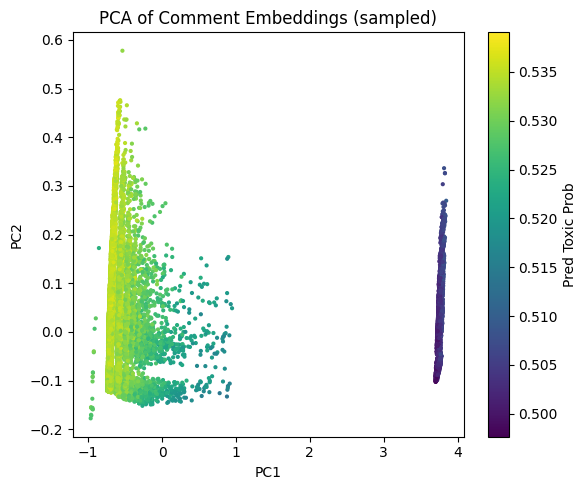

In [27]:
# PCA projection of hidden_comment to visualize score clusters (with sampling for large N)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

emb = hidden_comment.detach().cpu().numpy()
N = emb.shape[0]
max_points = 50000  # cap to avoid OOM and slow plotting
rng = np.random.RandomState(42)
if N > max_points:
    idx = rng.choice(N, size=max_points, replace=False)
    emb_plot = emb[idx]
    scores_plot = scores[idx] if isinstance(scores, np.ndarray) and scores.shape[0]==N else None
else:
    emb_plot = emb
    scores_plot = scores if isinstance(scores, np.ndarray) and scores.shape[0]==N else None

# Filter out any rows with NaN or Inf to satisfy PCA
finite_mask = np.isfinite(emb_plot).all(axis=1)
if scores_plot is not None:
    scores_plot = scores_plot[finite_mask]
emb_plot = emb_plot[finite_mask]

# Guard: need at least 2 samples and 2 features for PCA to 2D
if emb_plot.shape[0] < 2 or emb_plot.shape[1] < 2:
    print(f"Skipping PCA: insufficient data after filtering (shape={emb_plot.shape}).")
else:
    pca = PCA(n_components=2, random_state=42)
    xy = pca.fit_transform(emb_plot)
    plt.figure(figsize=(6,5))
    cvals = scores_plot if scores_plot is not None and scores_plot.shape[0]==xy.shape[0] else None
    sc = plt.scatter(xy[:,0], xy[:,1], c=cvals, cmap='viridis' if cvals is not None else None, s=4)
    if cvals is not None:
        plt.colorbar(sc, label='Pred Toxic Prob')
    plt.title('PCA of Comment Embeddings (sampled)' if N>max_points else 'PCA of Comment Embeddings')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.tight_layout()
    plt.show()

## 3. Attach Predictions & Export

## 3. Visualize Predictions

In [28]:
import pandas as pd, time
cid_col = config.get('comment_id_col','CommentId')
user_col = config.get('user_col','UserId')
pred_df = df[[cid_col, user_col]].copy()
pred_df['PredToxicProb']=scores
pred_df['PredToxicLabel']=(pred_df['PredToxicProb']>0.5).astype(int)
stamp=time.strftime('%Y%m%d_%H%M%S')
out_path=f'artifacts/predictions_{stamp}.csv'
Path('artifacts').mkdir(exist_ok=True)
pred_df.to_csv(out_path, index=False)
print('Wrote', out_path)
pred_df.head()

Wrote artifacts/predictions_20250918_230939.csv


,CommentID,AuthorChannelID,PredToxicProb,PredToxicLabel
0,UgyRjrEdJIPrf68uND14AaABAg,UC_-UEXaBL1dqqUPGkDll49A,0.528963,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,UCZ1LcZESjYqzaQRhjdZJFwg,0.529275,1
2,UgxB0jh2Ur41mcXr5IB4AaABAg,UCWBK35w5Swy1iF5xIbEyw3A,0.530575,1
3,UgwMOh95MfK0GuXLLrF4AaABAg,UCwQ2Z03nOcMxWozBb_Cv66w,0.528144,1
4,UgxJuUe5ysG8OSbABAl4AaABAg,UCTTcJ0tsAKQokmHB2qVb1qQ,0.529948,1


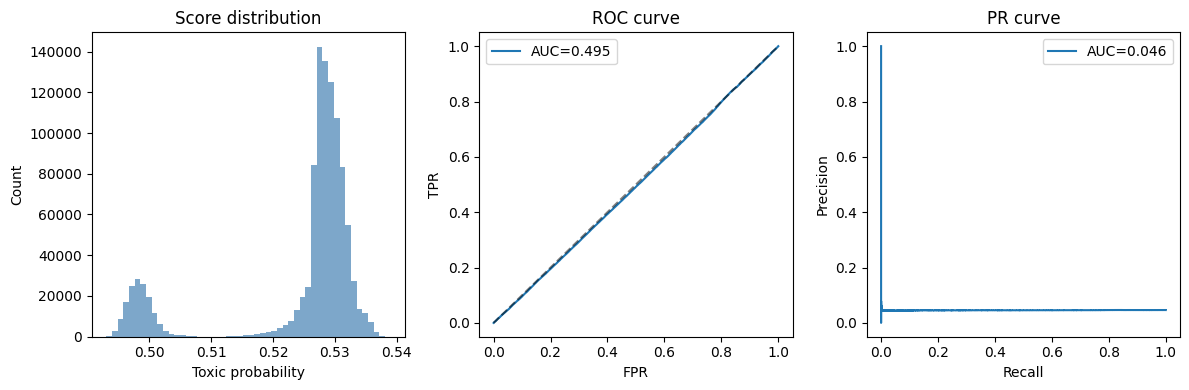

Confusion @0.5:
 [[113816 870461]
 [  5587  42361]]
Best threshold=0.01 | F1=0.089
Confusion @best:
 [[     0 984277]
 [     0  47948]]
Best threshold=0.01 | F1=0.089
Confusion @best:
 [[     0 984277]
 [     0  47948]]


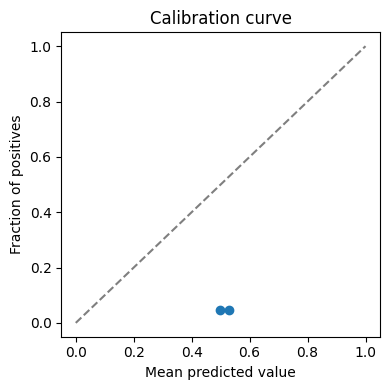

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve

y_true = hetero_inf['comment'].y.detach().numpy() if 'comment' in hetero_inf.node_types else None
scores_arr = scores
labels_available = y_true is not None and len(np.unique(y_true))>1

# Score histogram
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.hist(scores_arr, bins=50, alpha=0.7, color='steelblue')
plt.title('Score distribution')
plt.xlabel('Toxic probability')
plt.ylabel('Count')

# ROC and PR if labels available
if labels_available:
    fpr, tpr, _ = roc_curve(y_true, scores_arr)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1,3,2)
    plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend()

    precision, recall, _ = precision_recall_curve(y_true, scores_arr)
    pr_auc = auc(recall, precision)
    plt.subplot(1,3,3)
    plt.plot(recall, precision, label=f'AUC={pr_auc:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR curve')
    plt.legend()
else:
    plt.subplot(1,3,2)
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix at 0.5 and tuned threshold, if labels available
if labels_available:
    cm_05 = confusion_matrix(y_true, (scores_arr>=0.5).astype(int))
    print('Confusion @0.5:\n', cm_05)
    # simple threshold tuning for demo
    grid = np.linspace(0.01,0.99,99)
    best_t, best_f1 = 0.5, -1
    from sklearn.metrics import f1_score
    for t in grid:
        f1 = f1_score(y_true, (scores_arr>=t).astype(int))
        if f1>best_f1:
            best_t, best_f1 = t, f1
    cm_bt = confusion_matrix(y_true, (scores_arr>=best_t).astype(int))
    print(f'Best threshold={best_t:.2f} | F1={best_f1:.3f}\nConfusion @best:\n', cm_bt)

    # Calibration curve
    prob_true, prob_pred = calibration_curve(y_true, scores_arr, n_bins=10)
    plt.figure(figsize=(4,4))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    plt.title('Calibration curve')
    plt.tight_layout()
    plt.show()